# Case Study Data

There are 20 anonimyzed episodes where the episodes from 1 to 12 are Run-To-Failure episodes while the remaining 8 are episodes that end without any failure (from 13 to 20). These epiodes can be derived from different types of modules.

Data can been found in directory **\CaseStudyData**, moreover there is a file **maintenances.csv** which indicate the indexes which a module was replaced. (Usefull for reseting policy)

## Load, Run and Evaluate

In [1]:
import pandas as pd
import methods
import evaluation
from matplotlib import pyplot as plt


numpy.ndarray size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject
Using backend: pytorch


#### Load maintenances indexes, which will be used for PBr (Profile based with resets) and indexes that shall be ingored

In [2]:
dfresets=pd.read_csv(f"CaseStudyData/maintenances.csv",index_col=0)

allResets=dfresets.values.flatten()

# known deviating periods unrelated to failures, or periods that we want to ignore for evaluation. 
allingoreindexes=[]
ignoredf=pd.read_csv(f"CaseStudyData/ignoreindexes.csv",index_col=0)
for start,end in zip(ignoredf['start'],ignoredf['end']):
    allingoreindexes.append((start,end))

Helpfull function to transform indexes of maintenances in positions for each epiosode.

In [3]:
def episoderesets(episodedf,allResets):
    episoderesets=[]
    for reset in allResets:
        if reset in list(df.index):
            episoderesets.append(reset-episodedf.index[0])
    return episoderesets

### Testing Profile based with features with reseting

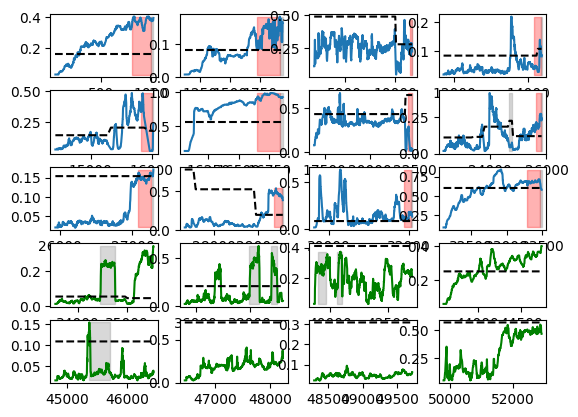

F2: AD1 0.4852823703129917,AD2 0.42579345630746623,AD3 0.3491527272447874
Recall: AD1 0.9166666666666666,AD2 0.6892820953161437,AD3 0.4772849690355068
Precission: 0.16836027713625867


In [4]:
predictions=[]
thresholds=[]
indexes=[]
isfailure=[]
for episode in range(1,21):
    if episode<13:
        isfailure.append(1)
    else:
        isfailure.append(0)
    
    df=pd.read_csv(f"CaseStudyData/Episode{episode}.csv",index_col=0)
    
    dfFeats=methods.calculateFeatures(df)
    
    
    #calculate resets for that episode (position of index)
    ep_resets=episoderesets(dfFeats,allResets)
    
    allerrors,allindexes,allthresholds=methods.profileBasedWithResets(dfFeats,ep_resets,metric="euclidean",profileSize=60,factor=6.5,window_ma=30)

    predictions.append(allerrors)
    thresholds.extend(allthresholds)
    indexes.append(allindexes)
    
recall,Precision,fbeta,axes=evaluation.myeval(predictions,thresholds,datesofscores=indexes,PH="210",lead="26",beta=2,isfailure=isfailure,ignoredates=allingoreindexes)
plt.show()
print(f"F2: AD1 {fbeta[0]},AD2 {fbeta[1]},AD3 {fbeta[2]}")
print(f"Recall: AD1 {recall[0]},AD2 {recall[1]},AD3 {recall[2]}")
print(f"Precission: {Precision}")

### Testing Profile based with SBT

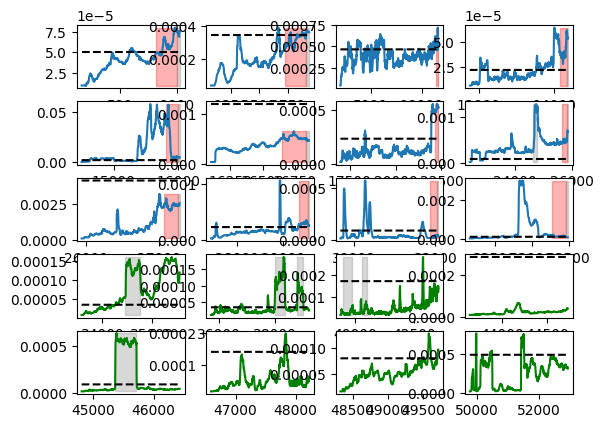

F2: AD1 0.3887293610911702,AD2 0.36642306130734875,AD3 0.3033857928753048
Recall: AD1 0.75,AD2 0.6539855072463768,AD3 0.4468484700437678
Precission: 0.13281824871228845


In [4]:
predictions=[]
thresholds=[]
isfailure=[]
indexes=[]
for episode in range(1,21):
    if episode<13:
        isfailure.append(1)
    else:
        isfailure.append(0)
    
    episodedf=pd.read_csv(f"CaseStudyData/Episode{episode}.csv",index_col=0)
    episodedf = episodedf.sub(episodedf.min(axis=1), axis=0).div(episodedf.max(axis=1) - episodedf.min(axis=1), axis=0)

    # horizontal normalization
    
    anomalyscores,threshold=methods.profileBased(episodedf,metric="cc",profileSize=100,factor=6.5,window_ma=30)
    predictions.append(anomalyscores)
    thresholds.append(threshold)
    indexes.append(list(episodedf.index[-len(anomalyscores):]))


recall,Precision,fbeta,axes=evaluation.myeval(predictions,thresholds,datesofscores=indexes,PH="210",lead="26",beta=2,isfailure=isfailure,ignoredates=allingoreindexes)
plt.show()
print(f"F2: AD1 {fbeta[0]},AD2 {fbeta[1]},AD3 {fbeta[2]}")
print(f"Recall: AD1 {recall[0]},AD2 {recall[1]},AD3 {recall[2]}")
print(f"Precission: {Precision}")